## Step 0. Folder Structure
```
3. Deep Learning Project/
├── dataset_split/
│   ├── train/
│   │   ├── african_elephant (780 images)
│   │   ├── airliner (780 images)
│   │   └── ... (8 more folders)
│   ├── val/
│   │   ├── african_elephant (260 images)
│   │   ├── airliner (260 images)
│   │   └── ... (8 more folders)
│   └── test (2600 images)
├── data_preprocessed/
│   ├── labels_train.pt
│   ├── labels_val.pt
│   ├── tensor_test.pt
│   ├── tensor_train.pt
│   └── tensor_val.pt
├── models/
│   ├── resnet18_checkpoint.pkl
│   └── resnet34_checkpoint.pkl
├── src/
│   └── part3.ipynb
├── src_datasplit/
│   └── data_split.ipynb
├── MSA.yaml
├── README.md
└── IEEE_Report_Template.docx
```


In [1]:
# TODO: Import the libraries.
from typing import Tuple, List
import os
import cv2
from tqdm import tqdm
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict
import copy
import matplotlib.pyplot as plt
import csv

## Step 1 Preprocessing
1. Load images and labels from folders into lists.
2. Resize the images.
3. Convert the image data type as float32 and limit the range in [0, 1].
4. Convert data from NHWC to NCHW and creat a PyTorch tensor from it.
5. Per-channel standardization of the dataset using training set statistics (mean and std computed independently for each color channel).
6. Saving the pre-processed sets as .pt files in the correct directory.
7. Load the pre-processed sets from .pt files. 

In [2]:
# TODO: 1. Load images from folder into a list.
def image_loader(set_dir: str) -> Tuple[List[np.ndarray], List[str]]:
    """
    Load all images from a dataset directory (train/val/test) into memory.
    
    Parameters:
    -----------
    set_dir : str
        Path to the directory containing either:
        - Class subdirectories (for train/val sets)
        - Direct image files (for test set)
        
    Returns:
    --------
    Tuple[List[np.ndarray], List[str]]
        images: List of BGR images (HWC format, uint8 dtype)
        labels: List of string labels (empty for test set)
    """
    images = []
    labels = []

    # Check if this is a test set (images directly inside the folder)
    subdirs = [d for d in os.listdir(set_dir) if os.path.isdir(os.path.join(set_dir, d))]
    
    if len(subdirs) == 0:
        # Test set: load files in filename order
        for fname in sorted(os.listdir(set_dir), key=lambda x: int(os.path.splitext(x)[0])):
            img_path = os.path.join(set_dir, fname)
            img = cv2.imread(img_path)
            if img is not None:
                images.append(img)
        labels = []  # no labels for test set

    else:
        # Train/val set: subdirectories = class names
        for label in sorted(subdirs):
            class_path = os.path.join(set_dir, label)
            for fname in os.listdir(class_path):
                img_path = os.path.join(class_path, fname)
                img = cv2.imread(img_path)
                if img is not None:
                    images.append(img)
                    labels.append(label)

    return images, labels


In [3]:
# TODO: 2. Resize images.
def img_resize(images: List[np.ndarray], target_size: int = 224) -> np.ndarray:
    if len(images) == 0:
        return np.array([])

    processed_images = []
    skipped_count = 0

    for img in images:
        if img is None or len(img.shape) != 3 or img.shape[2] != 3:
            skipped_count += 1
            continue

        h, w = img.shape[:2]
        scale = target_size / min(h, w)
        new_w, new_h = int(w * scale), int(h * scale)

        resized = cv2.resize(img, (new_w, new_h))
        start_x = (new_w - target_size) // 2
        start_y = (new_h - target_size) // 2
        cropped = resized[start_y:start_y + target_size, start_x:start_x + target_size]

        if cropped.shape == (target_size, target_size, 3):
            processed_images.append(cropped)
        else:
            skipped_count += 1

    print(f"Processed: {len(processed_images)} images")
    print(f"Skipped: {skipped_count} images")

    return np.stack(processed_images) if processed_images else np.array([])



In [4]:
# Load images

images_train, labels_train = image_loader(
    "C:/Users/sherr/NZMSA 2025-Phase-2 main data-science-3. Deep Learning Project_dataset_split_train"
)

images_val, labels_val = image_loader(
    "C:/Users/sherr/NZMSA 2025-Phase-2 main data-science-3. Deep Learning Project_dataset_split_val"
)

images_test, _ = image_loader(
    "C:/Users/sherr/NZMSA 2025-Phase-2 main data-science-3. Deep Learning Project_dataset_split_test"
)


In [5]:
# Resize the images

images_train = img_resize(images_train, 224)
images_val = img_resize(images_val, 224)
images_test = img_resize(images_test, 224)

Processed: 7316 images
Skipped: 484 images
Processed: 2452 images
Skipped: 148 images
Processed: 2430 images
Skipped: 170 images


In [6]:
# TODO: 3. Convert the image data type as float32 and limit the range in [0, 1].

images_train = images_train.astype(np.float32) / 255.0
images_val = images_val.astype(np.float32) / 255.0
images_test = images_test.astype(np.float32) / 255.0

In [7]:
# TODO: 4. Convert data from NHWC to NCHW and creat a PyTorch tensor from it.

tensor_train = torch.from_numpy(images_train).permute(0, 3, 1, 2)
tensor_val = torch.from_numpy(images_val).permute(0, 3, 1, 2)
tensor_test = torch.from_numpy(images_test).permute(0, 3, 1, 2)

In [8]:
# TODO: 5. Per-channel standardization of the dataset using training set statistics (mean and std computed independently for each color channel).


train_mean = tensor_train.mean(dim=(0, 2, 3), keepdim=True)
train_std = tensor_train.std(dim=(0, 2, 3), keepdim=True)


tensor_train = (tensor_train - train_mean) / train_std
tensor_val = (tensor_val - train_mean) / train_std
tensor_test = (tensor_test - train_mean) / train_std

In [9]:
# TODO: 6. Save the pre-processed sets as .pt files.
import json

# 6.1 Save tensors
torch.save(tensor_train, "E:/tensor_train.pt")
torch.save(tensor_val, "E:/tensor_val.pt")
torch.save(tensor_test, "E:/tensor_test.pt")

# 6.2 Create label mappings
unique_labels = sorted(list(set(labels_train)))  # get sorted unique labels
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
index_to_label = {idx: label for label, idx in label_to_index.items()}

# 6.3 Map labels to indices
labels_train_index = [label_to_index[label] for label in labels_train]
labels_val_index = [label_to_index[label] for label in labels_val]

# Save label indices as tensors
torch.save(torch.tensor(labels_train_index), "E:/labels_train.pt")
torch.save(torch.tensor(labels_val_index), "E:/labels_val.pt")

# 6.4 Save mappings as JSON files 
with open("E:/label_to_index.json", "w") as f:
    json.dump(label_to_index, f)

with open("E:/index_to_label.json", "w") as f:
    json.dump(index_to_label, f)


In [10]:
# TODO: 7. Load the pre-processed sets from .pt files. The data can be used directly in future without pre-processing once more by loading from the folder.

tensor_train = torch.load("E:/tensor_train.pt",weights_only=False)
tensor_val = torch.load("E:/tensor_val.pt",weights_only=False)
tensor_test = torch.load("E:/tensor_test.pt",weights_only=False)

labels_train_index = torch.load("E:/labels_train.pt",weights_only=False)
labels_val_index = torch.load("E:/labels_val.pt",weights_only=False)

# Step 2 Train the teacher model (ResNet34)
1. Set hyperparameters for the training process.
2. Create a pretrained ResNet34.
3. Define the optimizer, loss function, etc.
4. Train ResNet34 and save the best-performing parameters to 'resnet34_checkpoint.pkl'.
5. Plot the loss and accuracy curves.

In [11]:
# Verify data shapes

num_classes = max(labels_train_index) + 1
print(num_classes)
print(tensor_train.shape)
print(tensor_val.shape)
print(tensor_test.shape)
print(labels_train_index.shape)
print(labels_val_index.shape)

tensor(10)
torch.Size([7316, 3, 224, 224])
torch.Size([2452, 3, 224, 224])
torch.Size([2430, 3, 224, 224])
torch.Size([7800])
torch.Size([2600])


In [12]:
# TODO: 1. Set hyperparameters for the training process.



MAX_EPOCH = 50         # Number of training epochs
INIT_LR = 0.001         # Initial learning rate (standard for Adam)
BATCH_SIZE = 64         # Batch size (adjust depending on your memory capacity)

# Specify the training device (automatically detects GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [15]:
# TODO: 2. Create a pretrained ResNet34.

import torchvision.models as models
import torch.nn as nn
from torchvision.models import ResNet34_Weights

# Load pretrained ResNet34 and modify final FC layer
# 2.1 Use torchvision to create a pretrained ResNet34.
resnet34 = models.resnet34(weights=ResNet34_Weights.DEFAULT)

# 2.2 Modify the output layer so that the model aligns with this project.
resnet34.fc = nn.Linear(resnet34.fc.in_features, len(torch.unique(labels_train_index)))

# 2.3 Move the model to selected device.
resnet34.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
# TODO: 3. Define the optimizer, loss function, etc.

import torch.optim as optim

# 3. Define optimizer and loss function
optimizer = optim.Adam(resnet34.parameters(), lr=INIT_LR)  # Using Adam optimizer
criterion = nn.CrossEntropyLoss()  # For multi-class classification


In [ ]:
# TODO: 4. Train ResNet34 and save the best-performing parameters to 'resnet34_checkpoint.pkl'.
# Hint: May not need too many epochs as this is a pretrained model.


from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import copy

# Ensure labels are matched correctly to image tensors
labels_train_index = [label_to_index[label] for i, label in enumerate(labels_train) if i < len(tensor_train)]
labels_val_index = [label_to_index[label] for i, label in enumerate(labels_val) if i < len(tensor_val)]

# Convert labels to tensors
labels_train_tensor = torch.tensor(labels_train_index)
labels_val_tensor = torch.tensor(labels_val_index)

# Create TensorDatasets
train_dataset = TensorDataset(tensor_train, labels_train_tensor)
val_dataset = TensorDataset(tensor_val, labels_val_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# Track metrics
train_accs_resnet34, train_losses_resnet34 = [], []
val_accs_resnet34, val_losses_resnet34 = [], []

best_acc = 0.0
best_model = None

# Training loop
for epoch in range(MAX_EPOCH):
    resnet34.train()
    correct = total = train_loss = 0

    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        output = resnet34(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        pred = output.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)

    train_acc = correct / total
    train_losses_resnet34.append(train_loss / len(train_loader))
    train_accs_resnet34.append(train_acc)

    # Validation
    resnet34.eval()
    correct = total = val_loss = 0
    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            output = resnet34(X)
            loss = criterion(output, y)

            val_loss += loss.item()
            pred = output.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)

    val_acc = correct / total
    val_losses_resnet34.append(val_loss / len(val_loader))
    val_accs_resnet34.append(val_acc)

    print(f"Epoch {epoch+1}/{MAX_EPOCH} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        best_model = copy.deepcopy(resnet34.state_dict())
        torch.save(best_model, "resnet34_checkpoint.pkl")
#This part is too slow to train in CPU environment, so I trained it in googlecolab with GPU environment instead. Please check googlecolab_resnet34_resnet18 file.

In [ ]:
# TODO: 5. Plot the loss and accuracy curves.
# check googlecolab file

# Step 3 Train the student model (ResNet18)
1. Set hyperparameters for the distillation process.
2. Create a NON-PRETRAINED ResNet18 and move the model to selected device.
3. Load the saved ResNet34 and move the model to selected device.
4. Define the optimizer, loss function, etc.
5. Train ResNet18 and save the best-performing parameters to 'resnet18_checkpoint.pkl'.
6. Plot the loss and accuracy curves.

In [17]:
# Verify data shapes

num_classes = max(labels_train_index) + 1
print(num_classes)
print(tensor_train.shape)
print(tensor_val.shape)
print(tensor_test.shape)
print(labels_train_index.shape)
print(labels_val_index.shape)

tensor(10)
torch.Size([7316, 3, 224, 224])
torch.Size([2452, 3, 224, 224])
torch.Size([2430, 3, 224, 224])
torch.Size([7800])
torch.Size([2600])


In [18]:
# TODO: 1. Set hyperparameters for the distillation process.

MAX_EPOCH =50
INIT_LR =0.001
BATCH_SIZE =64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

TEMPERATURE = 4.0  # Distillation temperature
LOSS_RATIO = 0.7 #  # Weight for KD loss vs CE loss

In [19]:
# TODO: 2. Create a NON-PRETRAINED ResNet18 and move the model to selected device.
# Create a NON-pretrained ResNet18
resnet18 = models.resnet18(weights=None)  # or pretrained=False in older versions

# Adjust the output layer to match your number of classes
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)  # replace num_classes with your actual number

# Move to selected device
resnet18 = resnet18.to(device)

In [ ]:
# TODO: 3. Load the saved ResNet34 and move the model to selected device.
# Hint: Enable the evaluation mode to prevent updating the parameters.
# Load the trained weights
resnet34.load_state_dict(torch.load('/content/drive/MyDrive/resnet34_checkpoint.pkl', map_location=device))

# Move to device
resnet34 = resnet34.to(device)

# Set to evaluation mode
resnet34.eval()

#resnet34_checkpoint.pkl has been saved in my google drive, please check the googlecolab_resnet34_resnet18 file.

In [20]:
# TODO: 4. Define the optimizer, loss function, etc.

# Define optimizer
optimizer = optim.Adam(resnet18.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Cross-Entropy Loss (can also be combined with KD loss later)
criterion = nn.CrossEntropyLoss()

In [ ]:
# TODO: 5. Train ResNet18 and save the best-performing parameters to 'resnet18_checkpoint.pkl'.
# Hint: Use the correct loss function for knowledge distillation.


T = 4.0         # Temperature for distillation
alpha = 0.7     # Balance between KD loss and CE loss


# Training loop
EPOCHS = 50
train_accs, train_losses = [], []
val_accs, val_losses = [], []
best_acc = 0.0
best_model = None

for epoch in range(EPOCHS):
    resnet18.train()
    total = correct = epoch_loss = 0

    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()

        # Student forward
        student_out = resnet18(X)

        # Teacher forward (no gradient update)
        with torch.no_grad():
            teacher_out = resnet34(X)

        # Calculate losses
        loss_ce = criterion_ce(student_out, y)
        loss_kd = F.kl_div(
            F.log_softmax(student_out / T, dim=1),
            F.softmax(teacher_out / T, dim=1),
            reduction='batchmean'
        ) * (T * T)

        # Combine the losses
        loss = alpha * loss_kd + (1 - alpha) * loss_ce
        loss.backward()
        optimizer.step()

        pred = student_out.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)
        epoch_loss += loss.item()

    scheduler.step()

    train_acc = correct / total
    train_loss = epoch_loss / len(train_loader)
    train_accs.append(train_acc)
    train_losses.append(train_loss)

    # Validation
    resnet18.eval()
    correct = total = val_loss = 0
    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            out = resnet18(X)
            loss = criterion_ce(out, y)
            pred = out.argmax(1)
            correct += (pred == y).sum().item()
            val_loss += loss.item()
            total += y.size(0)

    val_acc = correct / total
    val_loss = val_loss / len(val_loader)
    val_accs.append(val_acc)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{EPOCHS} - Train Acc: {train_acc:.4f}, Train Loss: {train_loss:.4f}, Val Acc: {val_acc:.4f}, Val Loss: {val_loss:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        best_model = resnet18.state_dict()
        torch.save(best_model, "resnet18_checkpoint.pkl")

#check googlecolab_resnet18 file

In [ ]:
# TODO: 6. Plot the loss and accuracy curves.
#check googlecolab_resnet34_resnet18 file


# Step 4 Predict labels in the testing set
1. Load the saved ResNet18 and move it to the selected device.
2. Do prediction using the images in the testing set.
3. Write the results into the CSV file for submission.

In [ ]:
# TODO: 1. Load the saved ResNet18 and move it to the selected device.
# Hint: Enable the evaluation mode to prevent updating the parameters.

# Load ResNet18 model
resnet18 = models.resnet18()
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)  # Make sure num_classes is defined
resnet18.load_state_dict(torch.load("resnet18_checkpoint.pkl", map_location=device))
resnet18.to(device)
resnet18.eval()  # Evaluation mode to freeze parameters


In [ ]:
# TODO: 2. Do prediction using the images in the testing set.
from torch.utils.data import TensorDataset, DataLoader

# Load tensor
tensor_test = torch.load("tensor_test.pt")  # Shape: [N, C, H, W]

# Create dummy file names for now (e.g., 0.jpg, 1.jpg, ...)
file_names = [f"{i}.jpg" for i in range(len(tensor_test))]

# Create DataLoader
test_dataset = TensorDataset(tensor_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

predictions = []

with torch.no_grad():
    for batch in test_loader:
        images = batch[0].to(device)
        outputs = resnet18(images)
        predicted = outputs.argmax(dim=1).cpu().tolist()
        predictions.extend(predicted)

#check googlecolab_resnet34_resnet18 file

In [ ]:
# TODO: 3. Write the results into the CSV file for submission.
# Hint: The CSV file should be in the format of 'file_name' and 'label'.
#       The submission.csv should look like:
#           file_name,label
#           0.jpg,sunglasses
#           ...

index_to_label = 
#check googlecolab_resnet34_resnet18 file

--- End of part3_submission.ipynb ---

Mounted at /content/drive


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 189MB/s]


Epoch 1/50 | Train Acc: 0.5452, Train Loss: 1.1918 | Val Acc: 0.5424, Val Loss: 1.1877
Epoch 2/50 | Train Acc: 0.6005, Train Loss: 0.9366 | Val Acc: 0.5408, Val Loss: 1.2742
Epoch 3/50 | Train Acc: 0.6225, Train Loss: 0.8688 | Val Acc: 0.5991, Val Loss: 0.9949
Epoch 4/50 | Train Acc: 0.6553, Train Loss: 0.7616 | Val Acc: 0.6387, Val Loss: 0.8213
Epoch 5/50 | Train Acc: 0.6733, Train Loss: 0.7230 | Val Acc: 0.6252, Val Loss: 0.8301
Epoch 6/50 | Train Acc: 0.6852, Train Loss: 0.6673 | Val Acc: 0.5893, Val Loss: 1.0483
Epoch 7/50 | Train Acc: 0.6934, Train Loss: 0.6680 | Val Acc: 0.6052, Val Loss: 0.9218
Epoch 8/50 | Train Acc: 0.7255, Train Loss: 0.5905 | Val Acc: 0.6101, Val Loss: 1.0015
Epoch 9/50 | Train Acc: 0.7473, Train Loss: 0.5529 | Val Acc: 0.6073, Val Loss: 0.9637
Epoch 10/50 | Train Acc: 0.7771, Train Loss: 0.4992 | Val Acc: 0.5824, Val Loss: 1.2365
Epoch 11/50 | Train Acc: 0.8088, Train Loss: 0.4509 | Val Acc: 0.5383, Val Loss: 1.7244
Epoch 12/50 | Train Acc: 0.8479, Train Lo

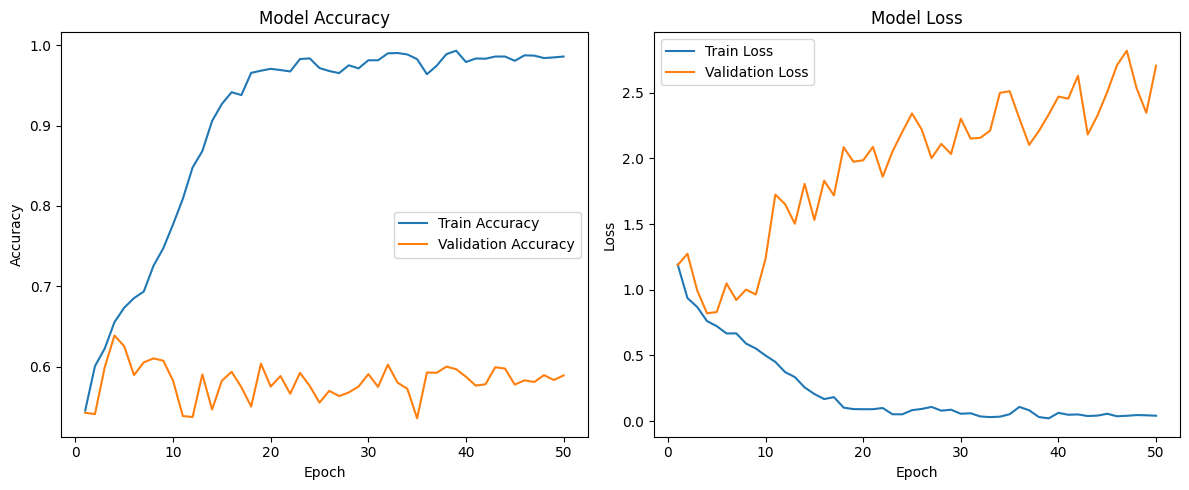

In [1]:
# Imports
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import resnet34, ResNet34_Weights
from torch.utils.data import TensorDataset, DataLoader
import json
import copy
import os
import torch.optim as optim

# Mount Google Drive and change to project path
from google.colab import drive
drive.mount('/content/drive')
project_path = '/content/drive/MyDrive'
os.chdir(project_path)

# Load preprocessed data
tensor_train = torch.load('/content/drive/MyDrive/tensor_train.pt')
tensor_val = torch.load('/content/drive/MyDrive/tensor_val.pt')
tensor_test = torch.load('/content/drive/MyDrive/tensor_test.pt')
labels_train_index = torch.load('/content/drive/MyDrive/labels_train.pt')
labels_val_index = torch.load('/content/drive/MyDrive/labels_val.pt')


# Align label sizes just in case
labels_train_index = labels_train_index[:tensor_train.shape[0]]
labels_val_index = labels_val_index[:tensor_val.shape[0]]

# Create datasets and loaders
BATCH_SIZE = 64
train_dataset = TensorDataset(tensor_train, labels_train_index)
val_dataset = TensorDataset(tensor_val, labels_val_index)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# Setup device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained ResNet34 and modify final FC layer
resnet34 = resnet34(weights=ResNet34_Weights.DEFAULT)
resnet34.fc = nn.Sequential(
    nn.Dropout(0.5),                      # Dropout layer
    nn.Linear(resnet34.fc.in_features, len(torch.unique(labels_train_index)))
)
resnet34.to(device)

# Define optimizer and loss
optimizer = torch.optim.Adam(resnet34.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

# Training loop
EPOCHS = 50
train_accs, val_accs = [], []
train_losses, val_losses = [], []
best_acc = 0.0
best_model = None

for epoch in range(EPOCHS):
    resnet34.train()
    correct = total = epoch_loss = 0

    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        out = resnet34(X)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        pred = out.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)
        epoch_loss += loss.item()

    train_acc = correct / total
    train_loss = epoch_loss / len(train_loader)
    train_accs.append(train_acc)
    train_losses.append(train_loss)

    # Validation
    resnet34.eval()
    correct = total = val_loss = 0
    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            out = resnet34(X)
            loss = criterion(out, y)
            pred = out.argmax(1)
            correct += (pred == y).sum().item()
            val_loss += loss.item()
            total += y.size(0)

    val_acc = correct / total
    val_loss = val_loss / len(val_loader)
    val_accs.append(val_acc)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{EPOCHS} | "
      f"Train Acc: {train_acc:.4f}, Train Loss: {train_loss:.4f} | "
      f"Val Acc: {val_acc:.4f}, Val Loss: {val_loss:.4f}")

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        best_model = copy.deepcopy(resnet34.state_dict())
        torch.save(best_model, "resnet34_checkpoint.pkl")  # saved in Google Drive

# Plot accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), train_accs, label='Train Accuracy')
plt.plot(range(1, EPOCHS + 1), val_accs, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), train_losses, label='Train Loss')
plt.plot(range(1, EPOCHS + 1), val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



Epoch 1/50 - Train Acc: 0.3524, Train Loss: 4.1583, Val Acc: 0.4086, Val Loss: 2.1679
Epoch 2/50 - Train Acc: 0.4437, Train Loss: 3.1418, Val Acc: 0.4209, Val Loss: 2.0210
Epoch 3/50 - Train Acc: 0.4738, Train Loss: 2.6030, Val Acc: 0.4682, Val Loss: 1.9327
Epoch 4/50 - Train Acc: 0.5109, Train Loss: 2.1075, Val Acc: 0.5061, Val Loss: 1.5653
Epoch 5/50 - Train Acc: 0.5309, Train Loss: 1.8666, Val Acc: 0.5033, Val Loss: 1.6882
Epoch 6/50 - Train Acc: 0.5447, Train Loss: 1.6283, Val Acc: 0.5746, Val Loss: 1.2326
Epoch 7/50 - Train Acc: 0.5638, Train Loss: 1.4787, Val Acc: 0.5636, Val Loss: 1.1569
Epoch 8/50 - Train Acc: 0.5767, Train Loss: 1.3618, Val Acc: 0.5632, Val Loss: 1.2733
Epoch 9/50 - Train Acc: 0.5951, Train Loss: 1.1785, Val Acc: 0.5363, Val Loss: 1.3471
Epoch 10/50 - Train Acc: 0.5973, Train Loss: 1.1032, Val Acc: 0.5865, Val Loss: 1.1484
Epoch 11/50 - Train Acc: 0.6428, Train Loss: 0.7976, Val Acc: 0.6073, Val Loss: 0.9994
Epoch 12/50 - Train Acc: 0.6505, Train Loss: 0.7294,

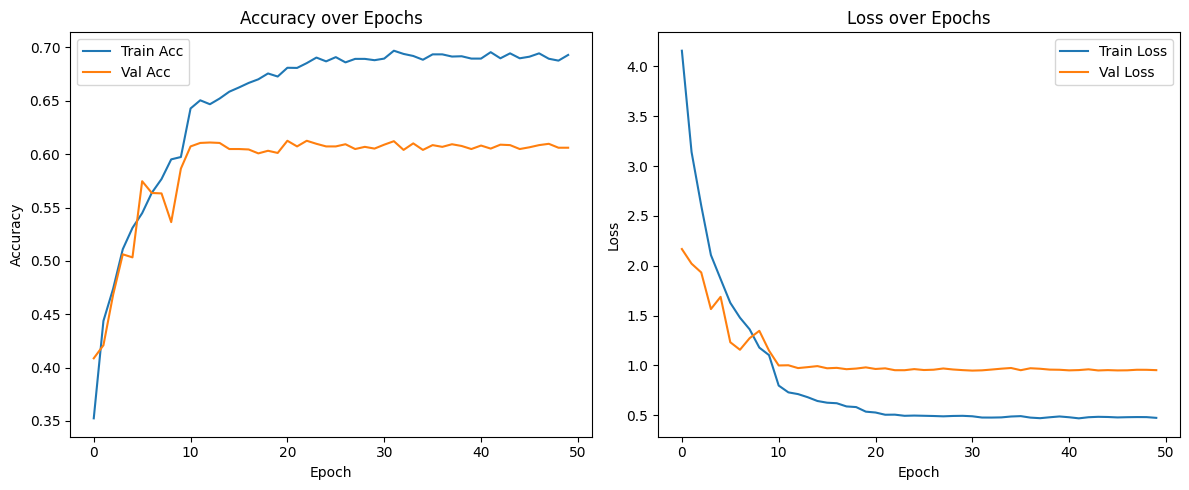

In [2]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchvision.models as models
import matplotlib.pyplot as plt
import copy
import torch.optim as optim

# Load tensors
tensor_train = torch.load('tensor_train.pt')
tensor_val = torch.load('tensor_val.pt')
labels_train = torch.load('labels_train.pt')
labels_val = torch.load('labels_val.pt')

# Match labels to tensors
labels_train = labels_train[:tensor_train.shape[0]]
labels_val = labels_val[:tensor_val.shape[0]]

# Datasets and loaders
BATCH_SIZE = 64
train_dataset = TensorDataset(tensor_train, labels_train)
val_dataset = TensorDataset(tensor_val, labels_val)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)


# Load trained ResNet34 as Teacher
# === Load ResNet34 and match architecture with saved checkpoint ===
resnet34 = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
resnet34.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(resnet34.fc.in_features, len(torch.unique(labels_train)))
)

# Load the trained model weights (checkpoint must match this architecture)
checkpoint_path = '/content/drive/MyDrive/resnet34_checkpoint.pkl'
resnet34.load_state_dict(torch.load(checkpoint_path, map_location=device))
resnet34.to(device)
resnet34.eval()

# Create Student: ResNet18 (non-pretrained)
resnet18 = models.resnet18(weights=None)  # NO pretrained weights
resnet18.fc = nn.Linear(resnet18.fc.in_features, len(torch.unique(labels_train)))
resnet18.to(device)

# Define optimizer
optimizer = optim.Adam(resnet18.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Cross-Entropy Loss (for ground truth supervision)
criterion_ce = nn.CrossEntropyLoss()


# Knowledge Distillation params
T = 4.0       # Temperature
alpha = 0.7   # Blend between KD and CE loss

# Training loop
EPOCHS = 50
train_accs, train_losses = [], []
val_accs, val_losses = [], []
best_acc = 0.0
best_model = None

for epoch in range(EPOCHS):
    resnet18.train()
    total = correct = epoch_loss = 0

    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()

        # Student forward
        student_out = resnet18(X)

        # Teacher forward (no gradient update)
        with torch.no_grad():
            teacher_out = resnet34(X)

        # Calculate losses
        loss_ce = criterion_ce(student_out, y)
        loss_kd = F.kl_div(
            F.log_softmax(student_out / T, dim=1),
            F.softmax(teacher_out / T, dim=1),
            reduction='batchmean'
        ) * (T * T)

        # Combine the losses
        loss = alpha * loss_kd + (1 - alpha) * loss_ce
        loss.backward()
        optimizer.step()

        pred = student_out.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)
        epoch_loss += loss.item()

    scheduler.step()

    train_acc = correct / total
    train_loss = epoch_loss / len(train_loader)
    train_accs.append(train_acc)
    train_losses.append(train_loss)

    # Validation
    resnet18.eval()
    correct = total = val_loss = 0
    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            out = resnet18(X)
            loss = criterion_ce(out, y)
            pred = out.argmax(1)
            correct += (pred == y).sum().item()
            val_loss += loss.item()
            total += y.size(0)

    val_acc = correct / total
    val_loss = val_loss / len(val_loader)
    val_accs.append(val_acc)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{EPOCHS} - Train Acc: {train_acc:.4f}, Train Loss: {train_loss:.4f}, Val Acc: {val_acc:.4f}, Val Loss: {val_loss:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        best_model = resnet18.state_dict()
        torch.save(best_model, "resnet18_checkpoint.pkl")

# Plot accuracy and loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.tight_layout()
plt.show()

In [3]:
# Load the training labels
labels_train = torch.load("labels_train.pt")

# Find the unique classes
unique_labels = torch.unique(labels_train)
num_classes = len(unique_labels)

print("Unique classes:", unique_labels)
print("Number of classes:", num_classes)

Unique classes: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Number of classes: 10


In [4]:
import torch
import torch.nn as nn
from torchvision import models
import csv

# 1. Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Load the number of classes
labels_train = torch.load("labels_train.pt")
unique_labels = torch.unique(labels_train)
num_classes = len(unique_labels)

# 3. Load test data
tensor_test = torch.load("tensor_test.pt")

# 4. Define model architecture
resnet18 = models.resnet18(weights=None)
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)

# 5. Load saved model parameters
resnet18.load_state_dict(torch.load("resnet18_checkpoint.pkl", map_location=device))
resnet18.to(device)
resnet18.eval()

# 6. Predict labels
predictions = []
with torch.no_grad():
    for i in range(len(tensor_test)):
        img = tensor_test[i].unsqueeze(0).to(device)  # add batch dimension
        output = resnet18(img)
        pred = output.argmax(1).item()
        predictions.append(pred)

# 7. Define index-to-label mapping
index_to_label = {
    0: "african_elephant",
    1: "airliner",
    2: "banana",
    3: "convertible_car",
    4: "golden_retriever",
    5: "goldfish",
    6: "parachute",
    7: "rugby",
    8: "sunglasses",
    9: "tiger_cat"
}

# 8. Save predictions to CSV
with open('submission.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['file_name', 'label'])

    for i, pred in enumerate(predictions):
        label_name = index_to_label[int(pred)]
        writer.writerow([f"{i}.jpg", label_name])


In [6]:
!pip install GPUtil

  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7392 sha256=4da21e3358518766ca4955af8976586f712d172096ed572d992d6d5c1271aace
  Stored in directory: /root/.cache/pip/wheels/2b/4d/8f/55fb4f7b9b591891e8d3f72977c4ec6c7763b39c19f0861595
Successfully built GPUtil


In [7]:
import torch
import torchvision.models as models
import time
import GPUtil
import gc

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get current GPU memory usage (in MB)
def get_current_gpu_memory():
    gpus = GPUtil.getGPUs()
    if gpus:
        return gpus[0].memoryUsed
    return 0

# Print model size and parameters
def model_stats(model, model_name="Model"):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    size_MB = total_params * 4 / (1024 ** 2)  # 4 bytes per float32
    print(f"{model_name} Total Parameters: {total_params:,}")
    print(f"{model_name} Trainable Parameters: {trainable_params:,}")
    print(f"{model_name} Estimated Model Size: {size_MB:.2f} MB\n")

# GPU info
def get_gpu_info():
    try:
        gpus = GPUtil.getGPUs()
        for gpu in gpus:
            print(f"GPU {gpu.id} - {gpu.name}")
            print(f"  Load: {gpu.load*100:.1f}%")
            print(f"  Free Memory: {gpu.memoryFree}MB / {gpu.memoryTotal}MB")
            print(f"  Used Memory: {gpu.memoryUsed}MB\n")
    except:
        print("No GPU or GPUtil not installed properly.")

# Inference time + GPU usage
def inference_time_with_gpu(model, model_name="Model", input_size=(1, 3, 224, 224)):
    model.eval()
    model.to(device)
    dummy_input = torch.randn(*input_size).to(device)

    torch.cuda.empty_cache()
    gc.collect()
    before_mem = get_current_gpu_memory()

    with torch.no_grad():
        start = time.time()
        for _ in range(100):
            _ = model(dummy_input)
        end = time.time()

    after_mem = get_current_gpu_memory()
    avg_time = (end - start) / 100
    print(f"{model_name} Inference Time: {avg_time*1000:.2f} ms/image")
    print(f"{model_name} GPU Memory Used: {after_mem - before_mem:.2f} MB\n")

# Training time + GPU usage
def training_time_with_gpu(model, model_name="Model", input_size=(64, 3, 224, 224), num_classes=10):
    model.train()
    model.to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    dummy_input = torch.randn(*input_size).to(device)
    dummy_target = torch.randint(0, num_classes, (input_size[0],)).to(device)

    torch.cuda.empty_cache()
    gc.collect()
    before_mem = get_current_gpu_memory()

    start = time.time()
    for _ in range(10):  # simulate 10 batches
        optimizer.zero_grad()
        output = model(dummy_input)
        loss = criterion(output, dummy_target)
        loss.backward()
        optimizer.step()
    end = time.time()

    after_mem = get_current_gpu_memory()
    avg_time = (end - start) / 10
    print(f"{model_name} Avg Training Time per batch: {avg_time:.3f} s")
    print(f"{model_name} GPU Memory Used: {after_mem - before_mem:.2f} MB\n")

# Run for a given model
def run_model_analysis(model_class, model_name):
    print(f"\n--- {model_name} ---")
    model = model_class()
    model_stats(model, model_name)
    inference_time_with_gpu(model, model_name)
    training_time_with_gpu(model, model_name)
    del model
    torch.cuda.empty_cache()
    gc.collect()

# Main
print("Initial GPU Info:")
get_gpu_info()

run_model_analysis(models.resnet34, "ResNet34")
run_model_analysis(models.resnet18, "ResNet18")

print("Final GPU Info:")
get_gpu_info()


Initial GPU Info:
GPU 0 - NVIDIA A100-SXM4-40GB
  Load: 0.0%
  Free Memory: 36574.0MB / 40960.0MB
  Used Memory: 3931.0MB


--- ResNet34 ---
ResNet34 Total Parameters: 21,797,672
ResNet34 Trainable Parameters: 21,797,672
ResNet34 Estimated Model Size: 83.15 MB

ResNet34 Inference Time: 5.16 ms/image
ResNet34 GPU Memory Used: 4.00 MB

ResNet34 Avg Training Time per batch: 0.036 s
ResNet34 GPU Memory Used: 3194.00 MB


--- ResNet18 ---
ResNet18 Total Parameters: 11,689,512
ResNet18 Trainable Parameters: 11,689,512
ResNet18 Estimated Model Size: 44.59 MB

ResNet18 Inference Time: 2.84 ms/image
ResNet18 GPU Memory Used: 4.00 MB

ResNet18 Avg Training Time per batch: 0.020 s
ResNet18 GPU Memory Used: 2574.00 MB

Final GPU Info:
GPU 0 - NVIDIA A100-SXM4-40GB
  Load: 100.0%
  Free Memory: 39552.0MB / 40960.0MB
  Used Memory: 953.0MB



In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(model, dataloader, device, model_name="Model"):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            preds = torch.argmax(outputs, dim=1)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"Evaluation Results for {model_name}")
    print(f"Accuracy :  {acc:.4f}")
    print(f"Precision:  {prec:.4f}")
    print(f"Recall   :  {rec:.4f}")
    print(f"F1-Score :  {f1:.4f}")

# Load best model checkpoints
resnet34.load_state_dict(torch.load("resnet34_checkpoint.pkl"))
resnet18.load_state_dict(torch.load("resnet18_checkpoint.pkl"))

# Evaluate on validation set
evaluate_model(resnet34, val_loader, device, model_name="ResNet34 (Teacher)")
evaluate_model(resnet18, val_loader, device, model_name="ResNet18 (Student)")


Evaluation Results for ResNet34 (Teacher)
Accuracy :  0.6387
Precision:  0.6427
Recall   :  0.6387
F1-Score :  0.6286
Evaluation Results for ResNet18 (Student)
Accuracy :  0.6126
Precision:  0.6131
Recall   :  0.6126
F1-Score :  0.6070


--- End of googlecolab_resnet34_resnet18.ipynb ---

In [1]:
import os

# Set your actual full paths here
train_path = r"C:\Users\sherr\NZMSA 2025-Phase-2 main data-science-3. Deep Learning Project_dataset_split_train"
val_path = r"C:\Users\sherr\NZMSA 2025-Phase-2 main data-science-3. Deep Learning Project_dataset_split_val"

# Define a dictionary to loop through both
datasets = {'TRAIN': train_path, 'VAL': val_path}

for name, path in datasets.items():
    print(f"\n=== {name} SET ===")
    
    for class_folder in sorted(os.listdir(path)):
        class_path = os.path.join(path, class_folder)
        if os.path.isdir(class_path):
            num_images = len([
                f for f in os.listdir(class_path)
                if os.path.isfile(os.path.join(class_path, f))
            ])
            print(f"{class_folder}: {num_images} images")



=== TRAIN SET ===
african_elephant: 780 images
airliner: 780 images
banana: 780 images
convertible_car: 780 images
golden_retriever: 780 images
goldfish: 780 images
parachute: 780 images
rugby: 780 images
sunglasses: 780 images
tiger_cat: 780 images

=== VAL SET ===
african_elephant: 260 images
airliner: 260 images
banana: 260 images
convertible_car: 260 images
golden_retriever: 260 images
goldfish: 260 images
parachute: 260 images
rugby: 260 images
sunglasses: 260 images
tiger_cat: 260 images


--- End of Count_image.ipynb ---